In [1]:
import os
import glob
import pickle
import gzip
import numpy as np
import pandas as pd

import tensorflow as tf
#tf.enable_eager_execution()

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
from matplotlib import pyplot as plt
%matplotlib inline
from werdich_cfr.tfutils.TFRprovider import DatasetProvider
from werdich_cfr.tfutils.Modeltrainer import VideoTrainer
from werdich_cfr.utils.visuals import ImageSliceViewer3D

TensorFlow Version: 2.1.0


### Recover data from TFRecords: look at the postprocessed images ###

In [2]:
# Directories and files
cfr_data_root = os.path.normpath('/mnt/obi0/andreas/data/cfr')
meta_date = '200208'
tfr_dir = os.path.join(cfr_data_root, 'tfr_'+meta_date)
meta_dir = os.path.join(cfr_data_root, 'metadata_'+meta_date)

# TFR file
tfr_file = os.path.join(tfr_dir, 'cfr_resized_a4c_train_200208_1.tfrecords')
parquet_file = os.path.join(tfr_dir, 'cfr_resized_a4c_train_200208_1.parquet')

# Load df 
df = pd.read_parquet(parquet_file)
df.head(50)

,mrn,study,echo_study_date,reportID,days_post_cfr,subjectid,report_number,cfr_study_date,cfr_report_date,cfr,filename,dir,datetime,fileid,institution,model,manufacturer,frame_time,number_of_frames,heart_rate,deltaX,deltaY,a2c,a2c_laocc,a2c_lvocc_s,a3c,a3c_laocc,a3c_lvocc_s,a4c,a4c_far,a4c_laocc,a4c_lvocc_s,a4c_rv,a4c_rv_laocc,a5c,apex,other,plax_far,plax_lac,plax_laz,plax_laz_ao,plax_plax,psax_avz,psax_az,psax_mv,psax_pap,rvinf,subcostal,suprasternal,max_view,mode,rate,im_array_shape
83091,1540947,4b7a826cb58d6913_4903a44516df7dbe0da035089a96,2006-04-19,85786,-225,1723,0607871K,2006-11-30,2006-04-19,1.003046,4b7a826cb58d6913_4903a44516df7dbe0da035089a96_...,/mnt/obi0/phi/echo/npyFiles/BWH/4b7a/4b7a826cb...,2006-04-19 16:26:32,4b7a826cb58d6913_4903a44516df7dbe0da035089a96_...,BWH,NA,Philips_Medical_Systems,33.000000,96.0,56.0,0.068052,0.054441,4.141169e-12,1.869846e-08,1.003276e-13,3.443188e-13,1.034783e-13,5.622636e-12,1.000000,1.051286e-08,6.757379e-11,2.952959e-11,1.496102e-14,6.830049e-14,1.754431e-13,1.585634e-13,7.590670e-12,1.790540e-12,1.061786e-14,3.461857e-13,1.712119e-14,9.724757e-12,7.152225e-13,5.908565e-12,3.865749e-12,6.979855e-10,1.509561e-16,4.563077e-16,7.794424e-17,a4c,train,30.3,"[234, 327, 40]"
125071,15302599,4a13402152a4fc32_4903a584a1b2945bd16771efa32d,2011-08-01,114848,-175,4781,EVS0312663,2012-01-23,2011-08-01,2.182906,4a13402152a4fc32_4903a584a1b2945bd16771efa32d_...,/mnt/obi0/phi/echo/npyFiles/BWH/4a13/4a1340215...,2011-08-01 14:11:51,4a13402152a4fc32_4903a584a1b2945bd16771efa32d_...,BWH,iE33,Philips Medical Systems,33.333000,67.0,55.0,0.035325,0.035325,9.463757e-14,4.190171e-18,3.305170e-15,7.078417e-15,2.497302e-15,4.097879e-14,1.000000,2.304627e-15,1.034795e-14,8.438240e-16,1.689003e-09,8.075573e-16,7.749743e-17,4.937970e-15,1.536190e-16,6.843063e-14,4.661182e-14,2.755383e-17,4.825358e-19,3.320423e-15,3.721341e-13,4.607266e-13,3.446470e-15,7.108752e-11,2.382514e-15,1.083428e-18,6.530801e-15,a4c,train,30.0,"[212, 283, 40]"
35628,18100198,4a1ed384c1fe94be_4903a5864e6e305b1eeb96e55085,2013-08-20,132796,-317,4072,EVS0436634,2014-07-03,2013-08-20,1.383901,4a1ed384c1fe94be_4903a5864e6e305b1eeb96e55085_...,/mnt/obi0/phi/echo/npyFiles/BWH/4a1e/4a1ed384c...,2013-08-20 15:25:25,4a1ed384c1fe94be_4903a5864e6e305b1eeb96e55085_...,BWH,iE33,Philips Medical Systems,33.333000,80.0,68.0,0.044038,0.044038,1.883996e-10,1.593052e-13,1.053540e-13,2.082665e-11,2.809025e-14,1.134101e-13,1.000000,4.007790e-13,1.299240e-15,2.396361e-14,6.854716e-10,3.386155e-13,2.198058e-12,1.814361e-12,6.442788e-14,5.003215e-15,6.542238e-14,4.519274e-13,9.537486e-15,6.947386e-12,1.648969e-12,1.840688e-12,1.302189e-13,2.757698e-08,5.284121e-13,2.148878e-15,3.982751e-12,a4c,train,30.0,"[264, 352, 40]"
127529,9304577,4b7290e890614054_4903a44ab128d8bfccf2376e65ee,2009-03-26,94096,0,2758,EVS0176807,2009-03-26,2009-03-26,1.993802,4b7290e890614054_4903a44ab128d8bfccf2376e65ee_...,/mnt/obi0/phi/echo/npyFiles/BWH/4b72/4b7290e89...,2009-03-26 14:34:44,4b7290e890614054_4903a44ab128d8bfccf2376e65ee_...,BWH,iE33,Philips Medical Systems,33.333000,91.0,58.0,0.039485,0.039485,6.557019e-13,1.476125e-13,2.018145e-15,1.591800e-14,4.626456e-16,4.282141e-14,1.000000,1.426456e-13,7.750098e-17,4.609982e-17,6.505001e-09,4.901330e-14,1.890907e-14,1.528885e-13,2.532345e-15,7.992240e-17,1.058236e-14,3.106873e-16,1.092509e-17,1.411857e-15,5.821931e-13,1.070180e-11,2.913540e-14,2.861726e-13,2.539068e-15,5.799589e-20,1.034618e-13,a4c,train,30.0,"[237, 316, 40]"
78613,21052774,49028a1fb2ca702e_4903a58793b43aa1aff31b524260,2012-03-17,115682,12,4848,EVS0352514,2012-03-05,2012-03-17,1.223700,49028a1fb2ca702e_4903a58793b43aa1aff31b524260_...,/mnt/obi0/phi/echo/npyFiles/BWH/4902/49028a1fb...,2012-03-17 11:46:17,49028a1fb2ca702e_4903a58793b43aa1aff31b524260_...,BWH,Vivid S6,GEMS Ultrasound,34.626313,65.0,83.0,0.052758,0.052758,1.429611e-08,4.520683e-11,3.836173e-10,9.104153e-11,9.172068e-09,3.559902e-08,0.999439,4.975051e-06,5.371658e-12,2.659786e-13,1.496665e-07,4.036836e-0

### Percentile thresholds for classification and image sizes ###

In [3]:
# TFR .parquet data files
train_files = glob.glob(os.path.join(tfr_dir, 'cfr_resized_a4c_train_200208_*.parquet'))
eval_files = glob.glob(os.path.join(tfr_dir, 'cfr_resized_a4c_eval_200208_*.parquet'))
test_files = glob.glob(os.path.join(tfr_dir, 'cfr_resized_a4c_test_200208_*.parquet'))

train_df = pd.concat([pd.read_parquet(file) for file in train_files])
eval_df = pd.concat([pd.read_parquet(file) for file in eval_files])
test_df = pd.concat([pd.read_parquet(file) for file in test_files])
dset = pd.concat([train_df, eval_df, test_df], axis = 0, ignore_index=True).reset_index(drop=True)
print(dset.shape)

(5064, 53)


In [4]:
print('Size of cfr table:', dset.shape)
cfr_array = dset.cfr.values
p_list = [np.round(np.percentile(cfr_array, p), decimals = 3) for p in (25, 50, 75)]
print('Percentile boundaries:', p_list)

Size of cfr table: (5064, 53)
Percentile boundaries: [1.259, 1.591, 2.066]


In [35]:
percentile_list = p_list
def cfr_p_label(cfr_value):
    return np.digitize(cfr_value, bins = percentile_list)
# Setting the threshold, check the number of positives and negatives
df['labelp'] = df['cfr'].apply(cfr_p_label)
print(df.labelp.iloc[0:10].values)

[0 3 1 2 0 0 0 3 1 2]


In [36]:
def cfr_label(cfr_value):
    if cfr_value < percentile_list[0]:
        label = 0
    elif cfr_value >= percentile_list[-1]:
        label = len(percentile_list)
    
    for p in range(1, len(percentile_list)):
        
        if (cfr_value >= percentile_list[p-1]) & (cfr_value < percentile_list[p]):
            label = p
    
    return label

df['label'] = df['cfr'].apply(cfr_label)
print(df.label.iloc[0:10].values)

[0 3 1 2 0 0 0 3 1 2]


In [37]:
label_list = sorted(df.label.unique())
print('Unique labels:', label_list)
df.head(20)
# Number of samples in each group
samples = [df[df.label == l].shape[0] for l in label_list]
for l in label_list:
    print('Label:', l, 'samples:', samples[l])

Unique labels: [0, 1, 2, 3]
Label: 0 samples: 319
Label: 1 samples: 362
Label: 2 samples: 362
Label: 3 samples: 366


### TFR extraction and postprocessing ###

In [5]:
n_frames=40
cfr_boundaries=(1.232, 1.556, 2.05)
output_height=299
output_width=299
#im_scale_factor=0.5642
im_scale_factor=0.849
record_output=False
batch_size=8

In [6]:
@tf.function
def cfr_label(cfr_value):
    ''' classification label for cfr value '''
    percentile_list = cfr_boundaries
    label = 0
    if cfr_value < percentile_list[0]:
        label = 0
    elif cfr_value >= percentile_list[-1]:
        label = len(percentile_list)
    for p in range(1, len(percentile_list)):
        if (cfr_value >= percentile_list[p - 1]) & (cfr_value < percentile_list[p]):
            label = p
    return tf.one_hot(label, depth = len(percentile_list)+1)

In [7]:
def parse(serialized):

    example = {'image': tf.io.FixedLenFeature([], tf.string),
               'shape': tf.io.FixedLenFeature([], tf.string),
               'cfr': tf.io.FixedLenFeature([], tf.float32),
               'record': tf.io.FixedLenFeature([], tf.int64)}

    # Extract example from the data record
    example = tf.io.parse_single_example(serialized, example)

    # Convert image to tensor and shape it
    image_raw = tf.io.decode_raw(example['image'], tf.uint16)
    shape = tf.io.decode_raw(example['shape'], tf.uint16)
    shape = tf.cast(shape, tf.int32) # tf.reshape requires int16 or int32 types
    image = tf.reshape(image_raw, shape)

    # Here, we have recovered the original shape of the images.
    # Now we need to process them.

    cfr = example['cfr']
    record = example['record']

    # categorical and regression outputs (tuple of dicts)
    if record_output:
        # Add record output for testing only (additional output gives an error during training)
        outputs = ({'video': process_image(image, shape)},
                   {'class_output': cfr_label(cfr),
                    'score_output': cfr},
                   {'record': record})
    else:
        # For training, use only model input/outputs
        outputs = ({'video': process_image(image, shape)},
                   {'class_output': cfr_label(cfr),
                    'score_output': cfr})
    return outputs

In [28]:
def process_image(image, shape):

    # original shape is [height, width, frames] -> [frames, height, width, 1]
    # If there is no scale-factor, the images will be resized to fit
    image = tf.reshape(image, shape=shape)
    image = tf.transpose(image, perm=[2, 0, 1])
    image = tf.expand_dims(image, axis=-1)

    if im_scale_factor is None:
        image = tf.image.resize_with_pad(image,
                                         target_height=output_height,
                                         target_width=output_width)
    else:
        # Re-size the image with a single scale factor, then pad to output_size
        im_size = tf.cast(tf.slice(shape, [0], [2]), dtype=tf.float32)
        new_im_size = tf.cast(tf.math.ceil(tf.math.scalar_mul(im_scale_factor, im_size)), tf.int32)
        image = tf.image.resize(image, size=new_im_size, antialias=True)
        # Crop or pad to the output size
        image = tf.image.resize_with_crop_or_pad(image,
                                                 target_height=output_height,
                                                 target_width=output_width)

    # Scale image to have mean 0 and variance 1
    #image = tf.cast(image, tf.float64)
    image = tf.cast(image, tf.float32)
    image = tf.image.adjust_contrast(image, contrast_factor=5)
    output_image = tf.image.per_image_standardization(image)

    return output_image

In [29]:
dataset = tf.data.TFRecordDataset([tfr_file])
        
# Parse records
dataset = dataset.map(map_func=parse, num_parallel_calls = None)

# Batch it up
dataset = dataset.batch(batch_size, drop_remainder=True)

# Prefetch
#dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset = dataset.repeat(count=1)

In [30]:
for out in dataset.take(1):
    output = out

# Output batch is a list of dictionaries [INPUT, OUTPUT]:
print('Input keys: ', output[0].keys())
print('Output keys:', output[1].keys())
image_batch = output[0]['video'].numpy()
print('Video batch shape:', image_batch.shape)
class_label_batch = output[1]['class_output'].numpy()
print('Class batch output shape:', class_label_batch.shape)
cfr_batch = output[1]['score_output'].numpy()
print('CFR batch output shape:', cfr_batch.shape)

Input keys:  dict_keys(['video'])
Output keys: dict_keys(['class_output', 'score_output'])
Video batch shape: (8, 40, 299, 299, 1)
Class batch output shape: (8, 4)
CFR batch output shape: (8,)


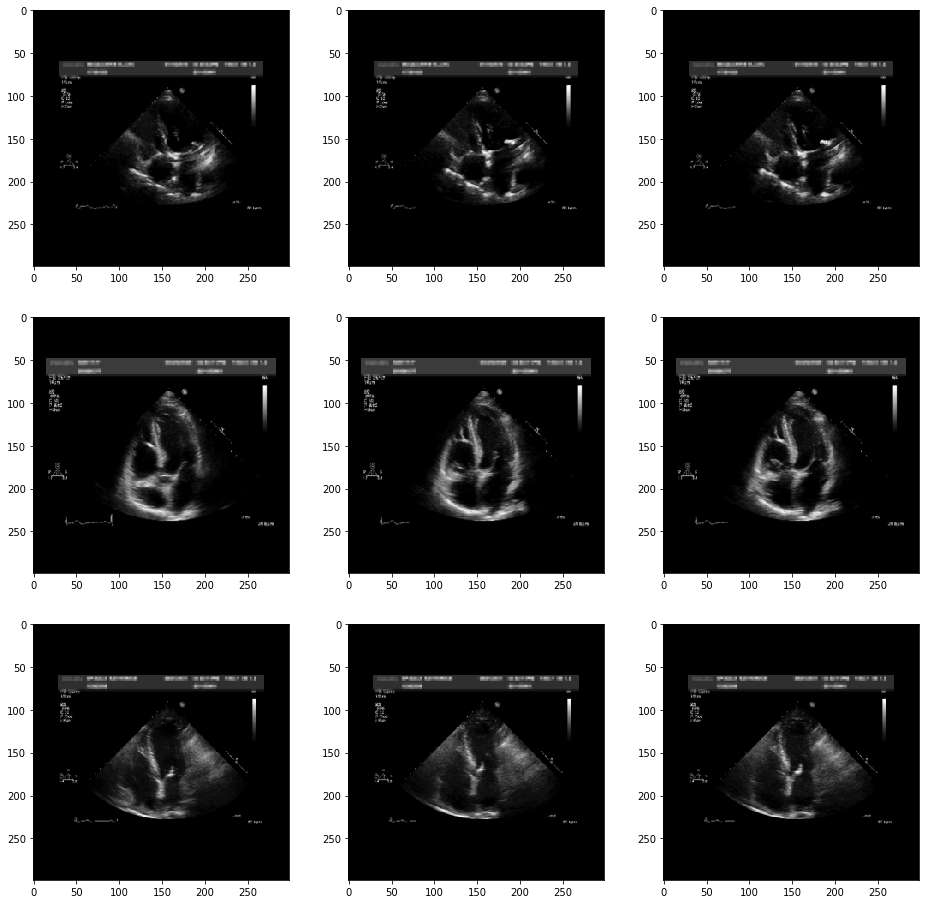

In [36]:
# Show some images from the batch
sample_idx = np.random.randint(batch_size, size=3)
frame_idx = np.random.randint(n_frames, size=3)

fig, ax = plt.subplots(nrows=len(sample_idx), ncols=len(frame_idx), figsize = (16,16))

for row, sample in enumerate(sample_idx):
    for col, frame in enumerate(frame_idx):
        image = np.squeeze(image_batch[sample, frame, :, :, 0])
        ax[row, col].imshow(image, cmap = 'gray')